In this notebook, we run some experiments on simulated data of **Hitting Time Prediction**.

In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")

import warnings
warnings.filterwarnings('ignore')

## Data generation & preprocessing

***Generate longitudinal markers***

**Paths** The paths are $5$-dimensional sample paths of a fractionnal brownian motion sampled at $100$ times over the time interval $[0,20]$. The different dimensions are independent. 

**Event definition** We consider the stochastic differential equation
\begin{align}
    dw_t & = -\theta\big(w_t-\mu\big)dt + (1,\dots,1)^\top d\mathbf{X}_t + \gamma W\\
    & = -\theta\big(w_t-\mu\big)dt + \sum\limits_{j=1}^d \alpha d\mathbf{X}^{(j)}_t + \gamma W
\end{align}
driven by the data, which we solve by computing its Euler-Maruyama discretization through 
\begin{align}
    w_{t+\Delta t} = w_t - \theta(w_t - \mu)\Delta t + \sum\limits_{j=1}^d \alpha \Delta \mathbf{X}^{(j)}_t + \gamma W.
\end{align}

We define the time-of-event as 
\begin{align}
    T^\star = \min \{ 0 \leq t \leq t^C  s.t. w_t \geq \kappa\}
\end{align}
where $\kappa \in \mathbb{R}$ is a threshold value i.e. the time-of-event is the hitting time of the barrier $\kappa$ of the solution to CDE. In this experiment, we set $\kappa=40$.

**Censorship** We censor individuals whose trajectory does not cross the threshold during the observation period. This means that individuals are never censored during the observation period, but only at the end.  

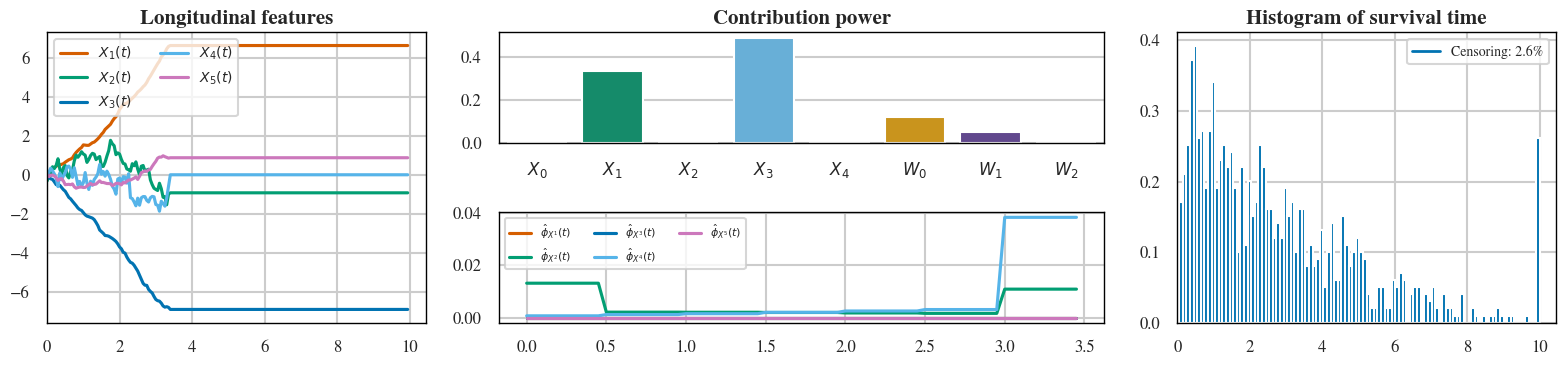

In [2]:
from examples.data.longi_simulation import longi_sim
n_longi_feats = 5
coefs = torch.Tensor([1, 0, 1., 0, 5., 0.])
coef_mask = torch.Tensor([1, 1, 1, 1, 1, 1])
important_feat_mask = torch.Tensor([0, 1, 0, 0, 0])
theta = torch.Tensor([0., -.3, 0., .2, 0.])
hurst_list = [0.9, 0.45, 0.85, 0.35, 0.8]
paths, surv_labels, static_feature, factor, ddh_info_sup, _, _ = longi_sim.Simulation().load(n_samples=1000, n_sampling_times = 200, end_time = 10, 
                                         dim=n_longi_feats + 1, intercept=True, threshold=12,
                                         coefs=coefs, coefs_mask=coef_mask, 
                                         important_feat_mask=important_feat_mask,
                                         hurst_list=hurst_list,
                                         theta=theta, n_static_feats=3)
important_feat_mask = (coefs != 0).int()
longi_feat_list = ['X'+ str(i+1) for i in range(n_longi_feats)]
n_samples, n_sampling_times, _ = paths.shape
sampling_times = paths[0, :, 0]
surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]
paths_init = paths.clone() # for MC true survival function

In [3]:
# Setup for experiment training
train_test_share = .8
n_samples = paths.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

paths_train = paths[train_index, :, :]
surv_labels_train = surv_labels[train_index, :]
if static_feature is not None:
    static_feature_train = static_feature[train_index, :]
else:
    static_feature_train = None

paths_test = paths[test_index, :, :]
surv_labels_test = surv_labels[test_index, :]
if static_feature is not None:
    static_feature_test = static_feature[test_index, :]
else:
    static_feature_test = None

## Cox Signature

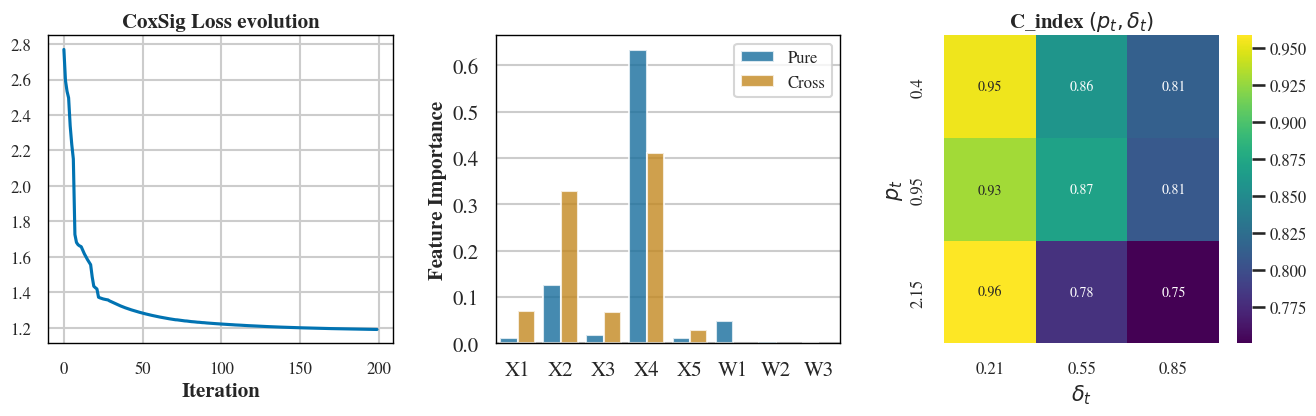

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

plt.subplots_adjust(hspace=.35, wspace=0.3)

### TRAINING
from examples.learner.coxsig import CoxSignature
sig_order = 2
coxsig = CoxSignature(sig_level=sig_order, alphas=3e-1, max_iter=200)
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
coxsig.train(paths_train, surv_labels_train, static_feature_train, plot_loss=True, ax=axs[0])


### FEATURE IMPORTANCE
from itertools import product
def get_all_combinations(feat_lst):
    all_combinations = []
    for r in range(1, sig_order + 1):  # r varies from 1 to length of feat_lst
        all_combinations.extend([p for p in product(feat_lst, repeat=r)])
    return all_combinations

combinations_list = get_all_combinations(np.arange(n_longi_feats + 1).tolist())

coef_df = pd.DataFrame(columns=["Feat", "Type", "Val"])
pfi_list = []
for i in range(1, n_longi_feats + 1):
    fi = 0
    for j in range(2):
        fi += coxsig.model.coefs[combinations_list.index((i,) * (j + 1))]**2
    pfi_list.append(round(np.sqrt(fi), 3))

pfi_df = pd.DataFrame(np.array([longi_feat_list, ["Pure"] * len(longi_feat_list), pfi_list]).T, columns=["Feat", "Type", "Val"])
coef_df = pd.concat((coef_df, pfi_df))
n_static_feat = static_feature.shape[1]
for j in range(n_static_feat):
    coef_df.loc[len(coef_df)] = ["W" + str(j+1), "Pure", (coxsig.model.coefs[-(n_static_feat - j)])**2]

cfi_list = []
for i in range(1, n_longi_feats + 1):
    fi = 0
    for j in range(len(combinations_list)):
        if i in combinations_list[j]:
            if (combinations_list[j] != (i,)) & (combinations_list[j] != (i, i ,)):
                fi += (coxsig.model.coefs[j])**2
    cfi_list.append(round(np.sqrt(fi), 3))

cfi_df = pd.DataFrame(np.array([longi_feat_list, ["Cross"] * len(longi_feat_list), cfi_list]).T, columns=["Feat", "Type", "Val"])
coef_df = pd.concat((coef_df, cfi_df))

coef_df["Val"] = pd.to_numeric(coef_df["Val"], errors="coerce")

sns.barplot(data=coef_df, x="Feat", y="Val", hue="Type", alpha=0.8, legend=True, ax=axs[1])
axs[1].set_xlabel("", fontweight="semibold", fontsize=15)
axs[1].tick_params(axis='x', labelsize=15)
axs[1].tick_params(axis='y', labelsize=15)
axs[1].set_ylabel("Feature Importance", fontweight="semibold", fontsize=15)
axs[1].legend(fontsize=12)


# setup
sampling_times = np.array(paths[0, :, 0])
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.1, .25, .5])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
n_eval_times = 3
eval_times = []
for k in range(n_eval_times):
    eval_times.append(max(np.quantile(np.array(tte), quantile_pred_times + (k+1) * .05) - pred_times))
eval_times = np.array(eval_times)

# evaluation
c_index = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index', static_feat = static_feature_test)

sns.heatmap(c_index, annot=True, annot_kws={"size": 10}, cmap="viridis", ax=axs[2])
axs[2].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs[2].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs[2].tick_params(axis='y', labelsize=12)
axs[2].tick_params(axis='x', labelsize=12)
axs[2].set_xlabel("$\delta_t$", fontweight="semibold", fontsize=15)
axs[2].set_ylabel("$p_t$", fontweight="semibold", fontsize=15)
axs[2].set_title("C_index $(p_t, \delta_t)$", fontweight="semibold", fontsize=15)
axs[2].collections[0].colorbar.ax.tick_params(labelsize=12)
axs[2].legend().remove()
plt.show()

## Explaination

In [5]:
from src.survinsights.longi_explainer import explainer
from src.survinsights.local_explaination._survlongishap import survshap_longi

quantile_pred_times = np.array([.5, .75])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
dt = sampling_times[1] - sampling_times[0]
all_shap = []
for pred_time in pred_times:
    sel_paths = paths[surv_labels[:, 0] > pred_time + 10 * dt]
    sel_static_feature = static_feature[surv_labels[:, 0] > pred_time + 10 * dt]
    sel_surv_labels = surv_labels[surv_labels[:, 0] > pred_time + 10 * dt]
    model_explainer = explainer(coxsig, "coxsig", sel_paths, sel_surv_labels, sel_static_feature)
    seed = 0
    shap_res = []
    K = min(10, int(.75 * sel_paths.shape[0]))
    for i in range(K):
        tmp = survshap_longi(model_explainer, i, sel_paths[i], sel_static_feature[i], pred_time=np.array([pred_time]), 
                                        prediction_type="survival", seed=seed, n_split=4, intercept=False, reg=4.)

        seed += 1
        shap_res.append(tmp)

    all_shap.append(shap_res)

[0. 0. 0. 1. 0. 0. 0. 0.]


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


[0.         0.         0.         0.04934994 0.         0.8916543
 0.05899575 0.        ]
[0.01296859 0.60498618 0.06229526 0.13003771 0.         0.
 0.18971226 0.        ]


100%|██████████| 1/1 [00:11<00:00, 11.60s/it]


[0.00000000e+00 9.35423635e-02 2.36325925e-02 5.56602883e-01
 0.00000000e+00 2.73525179e-01 5.23617214e-02 3.35260626e-04]


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


[0.00104101 0.96082356 0.00143753 0.01986555 0.         0.
 0.01477504 0.00205731]


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


[0.         0.90506613 0.01413645 0.08079742 0.         0.
 0.         0.        ]


100%|██████████| 1/1 [00:10<00:00, 10.83s/it]


[0.         0.         0.         0.72665849 0.         0.27334151
 0.         0.        ]


100%|██████████| 1/1 [00:04<00:00,  4.44s/it]


[0.0294701  0.38912338 0.01754464 0.46353846 0.00431422 0.
 0.0945081  0.0015011 ]


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


[0.         0.00714508 0.         0.66381977 0.         0.32903514
 0.         0.        ]


100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


[0.         0.         0.         0.61055486 0.         0.38944514
 0.         0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


[0.         0.0719542  0.         0.46275468 0.         0.41577639
 0.04951472 0.        ]


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


[0.         0.88165051 0.         0.01847372 0.         0.09987578
 0.         0.        ]


100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


[0.         0.79764718 0.03556119 0.1114117  0.         0.
 0.05537993 0.        ]


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


[0.03870803 0.41399236 0.0189716  0.52179449 0.00416766 0.
 0.         0.00236584]


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


[0.         0.39248443 0.         0.44323762 0.         0.16427795
 0.         0.        ]


100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


[0.         0.         0.         0.49424943 0.         0.50575057
 0.         0.        ]


100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


[0.         0.35780227 0.         0.43845934 0.         0.19113307
 0.01260532 0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


[0.00149151 0.55209332 0.05440713 0.35237482 0.         0.
 0.03877659 0.00085665]


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


[0.         0.10053448 0.01818295 0.4889189  0.         0.39236366
 0.         0.        ]


100%|██████████| 1/1 [00:10<00:00, 10.51s/it]


[0.         0.         0.         0.53484916 0.         0.46515084
 0.         0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


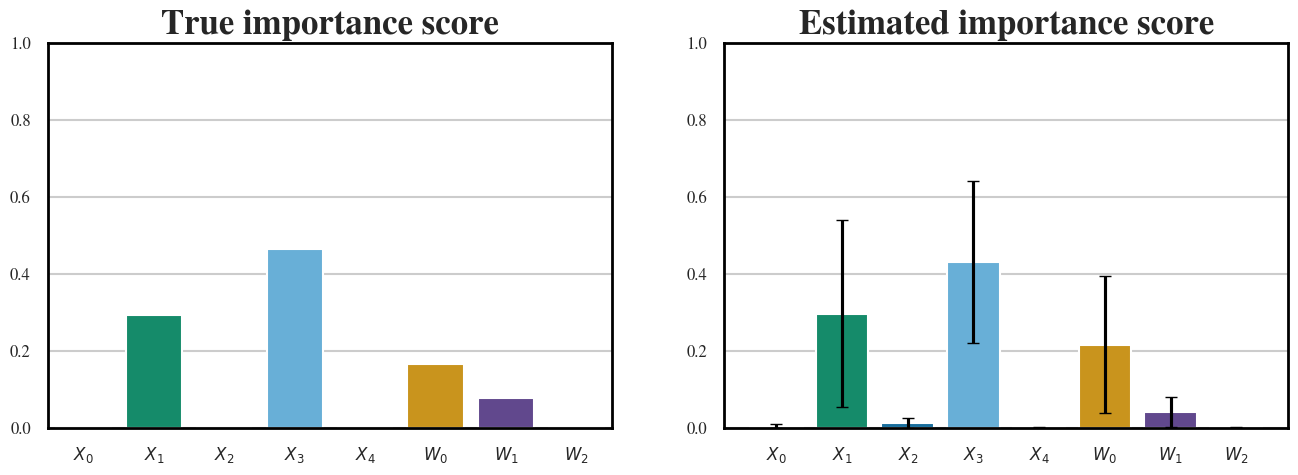

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

colors = ['r', 'g', 'b', 'c', 'm']

colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]
x_labels = ["$X_" + str(i) + "$" for i in range(n_longi_feats)] + ["$W_" + str(i) + "$" for i in range(n_static_feat)]

idx_pred_t = 0
pred_time = pred_times[idx_pred_t]
n_merged_time = 5
pred_time_idx = (int((pred_time  / (sampling_times[1] - sampling_times[0]))) // n_merged_time) * n_merged_time
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx-1:pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
factor_avg = (
    factor_ext
    .reshape(factor_ext.shape[0], -1, n_merged_time)
    .mean(axis=2, keepdims=True)
    .repeat(n_merged_time, axis=2)
    .reshape(factor_ext.shape[0], n_sampling_times)
)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)
sns.barplot(data=score_df, x="feat", y="value", ax=axs[0], palette=colors)
axs[0].tick_params(axis='x', labelsize=12) 
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[0].set_ylim(0, 1.)
axs[0].set_title("True importance score", fontweight="semibold", fontsize=25) 

##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap)
n_expl_samples = all_shap.shape[1]
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[1], palette=colors)
axs[1].errorbar(
    x=np.arange(std_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=std_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[1].tick_params(axis='x', labelsize=12) 
axs[1].tick_params(axis='y', labelsize=12)
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_ylim(0, 1.)
axs[1].set_title("Estimated importance score", fontweight="semibold", fontsize=25)
plt.show()

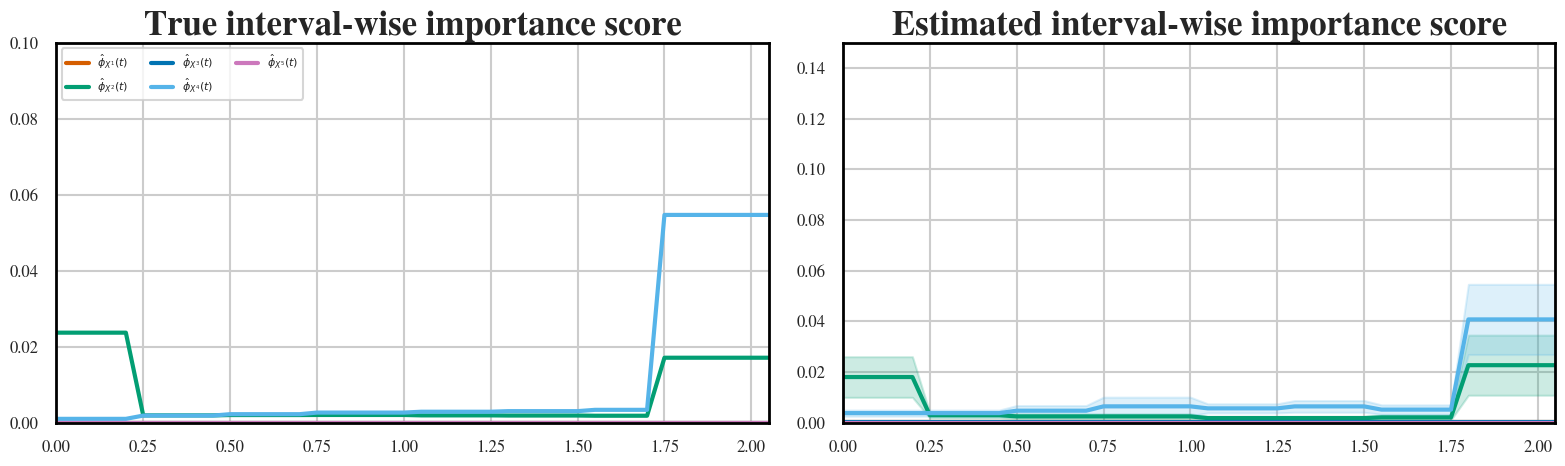

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]
x_labels = ["$X_" + str(i) + "$" for i in range(n_longi_feats)] + ["$W_" + str(i) + "$" for i in range(n_static_feat)]

idx_pred_t = 0
dt = sampling_times[1] - sampling_times[0]
##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))

pred_time = pred_times[idx_pred_t]
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx -1 :pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
interval = [0 , 5, 10, 15, 21, 26, 31, 35, 42]
factor_avg = factor_ext.copy()
for l in range(len(interval) - 1):
    factor_avg[:, interval[l] : interval[l+1]] = factor_avg[:, interval[l] : interval[l+1]].mean(axis=1).reshape(-1, 1)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)

# ---- LONGITUDINAL feature importance
for l, f in enumerate(factor_avg[:n_longi_feats]):
    label = f"$\\hat{{\\phi}}_{{X^{l+1}}}(t)$"
    axs[0].plot(sampling_times[: len(f)][:pred_time_idx], f[:pred_time_idx], label=label, linewidth=3, color=colors[l % len(colors)], linestyle="-")
axs[0].legend(ncols=3, fontsize=8, loc="upper left")
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_ylim(0, .1)
axs[0].set_xlim(0, (pred_time_idx - 1) * dt)
axs[0].set_title("True interval-wise importance score", fontweight="semibold", fontsize=25) 

for l in range(n_longi_feats):
    axs[1].plot(sampling_times, mean_shap_at_pt[l], label='$X_'+ str(l+1) + '$', linewidth=3, color=colors[l])
    axs[1].fill_between(sampling_times, mean_shap_at_pt[l] - std_shap_at_pt[l], mean_shap_at_pt[l] + std_shap_at_pt[l], color=colors[l], alpha=0.2)
axs[1].set_title("Estimated interval-wise importance score", fontweight="semibold", fontsize=25)
axs[1].tick_params(axis='x', labelsize=12) 
axs[1].tick_params(axis='y', labelsize=12)
axs[1].set_ylim(0, .15)
axs[1].set_xlim(0, (pred_time_idx - 1) * dt)
plt.tight_layout()
plt.savefig('shap_simu_2000_score_per_longi_pt1.pdf')
plt.show()